# Manual 04: Optimización Básica de Portafolio
## Universidad del Norte
### Economía Matemática
Miramos un poco práctico como optimizar un riesgo de elección de un par de acciones de la bolsa.

Paquetes que vamos a usar en la **sesión**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxpy import *

*En ocasiones al instalar cvxpy puede generar problemas* Hay que ver que sesion soporta el cvxpy con numpy. En ese caso se puede colocar `pip install numpy==1.26.4`

## Carga de datos
Procedemos a importar los datos de las acciones de Netflix, Crowstrike y las de Nu bank

In [2]:
mp = pd.read_excel("/Users/carlosandresyanesguerra/Documents/Ecomat/Data/monthly_prices.xlsx")
mr = pd.DataFrame()

In [3]:
mp.head()

,CRWD,NU,NFLX
0,342.16,10.36,891.32
1,345.97,12.53,886.81
2,296.87,15.09,756.03
3,280.47,13.65,709.27
4,277.28,14.97,701.35


Verifiquemos la data

In [4]:
print(mp.columns)

Index(['CRWD', 'NU', 'NFLX'], dtype='object')


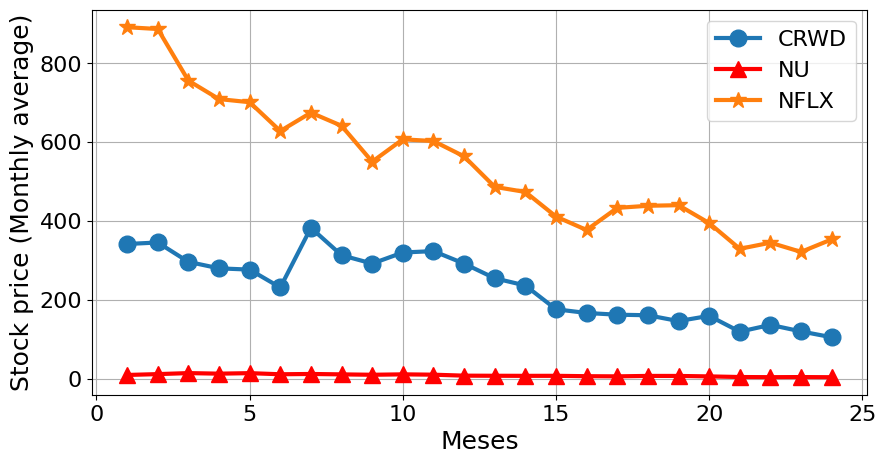

In [10]:
plt.figure(figsize=(10,5))
plt.plot([i for i in range(1,25)], mp['CRWD'], lw=3, marker='o', markersize=12)
plt.plot([i for i in range(1,25)], mp['NU'], lw=3, c='red', marker='^', markersize=12)
plt.plot([i for i in range(1,25)], mp['NFLX'], lw=3, marker='*', markersize=12)
plt.legend(mp.columns, fontsize=16)
plt.xlabel("Meses", fontsize=18)
plt.ylabel("Stock price (Monthly average)", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()


Las tres vienen descendiendo en el último periodo

In [6]:
for s in mp.columns:
    date = mp.index[0]
    pr0 = mp[s][date] 
    for t in range(1, len(mp.index)):
        date = mp.index[t]
        pr1 = mp[s][date]
        ret = (pr1 - pr0) / pr0
        mr.at[date, s] = ret  # <- reemplazo moderno de set_value a at
        pr0 = pr1

Recuerde que en el manejo de portafolios es nueno calcular el retorno de cada acción.

In [7]:
mr.head()

,CRWD,NU,NFLX
1,0.011135,0.209459,-0.005060
2,-0.141920,0.204310,-0.147472
3,-0.055243,-0.095427,-0.061849
4,-0.011374,0.096703,-0.011166
5,-0.163445,-0.189713,-0.104085


In [16]:
# get symbol names
symbols = mr.columns

Si $R_t= 1- \dfrac{x_t}{x_{t-1}}$. Vamos a convertir en una matriz de datos los retornos obtenidos

In [8]:
return_data = mr.to_numpy().T

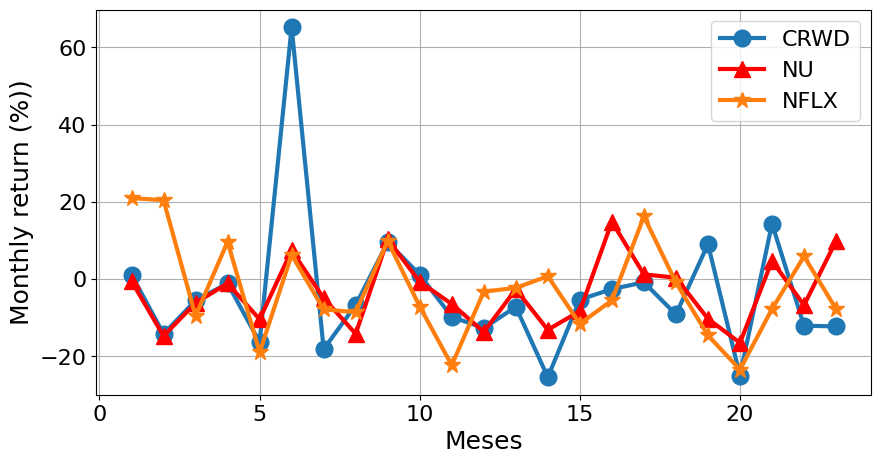

In [11]:
plt.figure(figsize=(10,5))
plt.plot([i for i in range(1,24)],100*mr['CRWD'],lw=3,marker='o',markersize=12)
plt.plot([i for i in range(1,24)],100*mr['NFLX'],lw=3,c='red',marker='^',markersize=12)
plt.plot([i for i in range(1,24)],100*mr['NU'],lw=3,marker='*',markersize=12)
plt.legend(mp.columns,fontsize=16)
plt.xlabel("Meses",fontsize=18)
plt.ylabel("Monthly return (%))",fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

### Medidas a considerar
Ahora vamos a calcular el valor esperado del Retorno $E(R_t)$, la matriz de covarianzas y finalmente el estamento de riesgo de cada una de las acciones

In [12]:
r = np.asarray(np.mean(return_data, axis=1))

In [14]:
C = np.asmatrix(np.cov(return_data))
C

matrix([[0.03270847, 0.00568517, 0.00827746],
        [0.00568517, 0.01553116, 0.00286835],
        [0.00827746, 0.00286835, 0.00774376]])

$$\begin{equation}
\text{E (ret)}_j = r_j
\end{equation}$$

$$\begin{equation}
\text{Risk}_j = \sqrt{C_{jj}}
\end{equation}$$

Donde:
- $C_{jj}$ es el valor en la diagonal de la matriz de covarianza $(C)$ correspondiente al símbolo $(j)$.

In [17]:
for j in range(len(symbols)):
    print ('%s: Exp ret = %f, Risk = %f' %(symbols[j],r[j], C[j,j]**0.5))

CRWD: Exp ret = -0.036533, Risk = 0.180855
NU: Exp ret = -0.026690, Risk = 0.124624
NFLX: Exp ret = -0.035596, Risk = 0.087999


## Modelo de optimización de portafolio

Llegó la hora de mirar que es lo mejor acá

In [18]:
# Variables
n = len(symbols)

# Vector X
x = Variable(n)

# Retorno mas pequeño
req_return = -0.03

# Retorno
ret = r.T*x

# Riesgo
risk = quad_form(x, C)

# Problema CVXPY
prob = Problem(Minimize(risk), [sum(x)==1, ret >= req_return, x >= 0])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


In [20]:
try:
    prob.solve()
    print ("Portafolio óptimo")
    print ("----------------------")
    for s in range(len(symbols)):
       print (" Inversión en {} : {}% del portafolio".format(symbols[s],round(100*x.value[s],2)))
    print ("----------------------")
    print ("Exp ret = {}%".format(round(100*ret.value,2)))
    print ("Expected risk    = {}%".format(round(100*risk.value**0.5,2)))
except:
    print ("Error")

Portafolio óptimo
----------------------
 Inversión en CRWD : 0.0% del portafolio
 Inversión en NU : 62.83% del portafolio
 Inversión en NFLX : 37.17% del portafolio
----------------------
Exp ret = -3.0%
Expected risk    = 9.24%


### Adicional
Podemos mirar que haya sido optimizado todo

In [21]:
prob.status

'optimal'

Valores normales sin aplicar (%)

In [22]:
x.value

array([1.16747830e-16, 6.28324572e-01, 3.71675428e-01])

## Ejercicio
1. Escoja 4 Acciones de Google Finance o Yahoo Finance y replique el portafolio. Explique concretamente lo que se hace

-----------------

*Todos los creditos son para el Dr. Tirthajyoti Sarkar y su trabajo con sus notas de clase y aporte directo*